In [1]:
# THIS CELL SETS STUFF UP FOR DEMO / COLLAB. THIS CELL CAN BE IGNORED.

#-------------------------------------GET RID OF TF DEPRECATION WARNINGS--------------------------------------#
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#----------------------------------INSTALL PSYCHRNN IF IN A COLAB NOTEBOOK-------------------------------------#
# Installs the correct branch / release version based on the URL. If no branch is provided, loads from master.
# Loads saved weights from correct branch and saves a local copy for later use.
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    import json
    import re
    import ipykernel
    import requests 
    from requests.compat import urljoin
    from io import BytesIO
    import numpy as np
    import os

    from notebook.notebookapp import list_running_servers
    kernel_id = re.search('kernel-(.*).json',
                          ipykernel.connect.get_connection_file()).group(1)
    servers = list_running_servers()
    for ss in servers:
        response = requests.get(urljoin(ss['url'], 'api/sessions'),
                                params={'token': ss.get('token', '')})
        for nn in json.loads(response.text):
            if nn['kernel']['id'] == kernel_id:
                relative_path = nn['notebook']['path'].split('%2F')
                if 'blob' in relative_path:
                  blob = relative_path[relative_path.index('blob') + 1]
                  !pip install git+https://github.com/murraylab/PsychRNN@$blob
                  file_location = "https://github.com/murraylab/PsychRNN/blob/" + blob + "/docs/notebooks/weights/saved_weights.npz?raw=true"
                else:
                  !pip install git+https://github.com/murraylab/PsychRNN
                  file_location = "https://github.com/murraylab/PsychRNN/docs/notebooks/weights/saved_weights.npz?raw=true"

    r = requests.get(file_location, stream = True)
    data = dict(np.load(BytesIO(r.raw.read()), allow_pickle = True))
    if not os.path.exists("./weights"):
        os.makedirs("./weights")
    np.savez("./weights/saved_weights.npz", **data)

# Simulation in NumPy
[Simulator](../apidoc/backend.rst#simulation) has NumPy implementations of the included models. Once the model is trained, experiments can be done entirely in NumPy without any reliance on TensorFlow, giving full control to researchers.

There may be some floating point error differences between NumPy and TensorFlow implementations -- these grow the more timepoints the model is run on, but shouldn't cause major issues.

Here we will demonstrate training a simple model in tensorflow, and then loading it and simulating it in NumPy.

The Simulator can be loaded either directly from a model, from saved weights in a file, or from a dictionary of weights. All options will be shown below.

In [2]:
from psychrnn.backend.models.basic import Basic
from psychrnn.backend.simulation import BasicSimulator
from psychrnn.tasks.perceptual_discrimination import PerceptualDiscrimination

import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

## Load from Model

To load from a model we first need to have a model. Here we instantiate a basic model from the weights saved out by [Simple Example](PerceptualDiscrimination.ipynb#Get-&-Save-Model-Weights).

In [3]:
network_params = {'N_batch': 50,
                  'N_in': 2,
                  'N_out': 2,
                  'dt': 10,
                  'tau': 100,
                  'T': 2000,
                  'N_steps': 200,
                  'N_rec': 50,
                  'name': 'Basic',
                  'load_weights_path': './weights/saved_weights.npz'
                 }
tf_model = Basic(network_params)

Instantiate the simulator from the model. Because the model was originally trained as a [Basic](../apidoc/backend.rst#module-psychrnn.backend.models.basic) model, we will use [BasicSimulator](../apidoc/backend.rst#psychrnn.backend.simulation.BasicSimulator) to simulate the model.

In [4]:
simulator = BasicSimulator(rnn_model = tf_model)

Instantiate task to run the simulator on:

In [5]:
pd = PerceptualDiscrimination(dt = 10, tau = 100, T = 2000, N_batch = 128)

### Simulate Model
Simulate [tf_model.test()](../apidoc/backend.rst#psychrnn.backend.rnn.RNN.test) using the simulator's NumPy impelmentation, [simulator.run_trials(x)](../apidoc/backend.rst#psychrnn.backend.simulation.BasicSimulator.run_trials).

In [6]:
x, y, mask, _ = pd.get_trial_batch()
outputs, states = simulator.run_trials(x)

We can plot the results form the simulated model much as we could plot the results from the model in [Simple Example](PerceptualDiscrimination.ipynb#Test-Model). 

Text(0.5, 1.0, 'Output on New Sample')

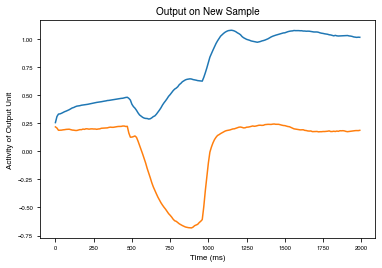

In [7]:
plt.plot(range(0, len(outputs[0,:,:])*10,10),outputs[0,:,:])
plt.ylabel("Activity of Output Unit")
plt.xlabel("Time (ms)")
plt.title("Output on New Sample")

Text(0.5, 1.0, 'Evolution of State Variables over Time')

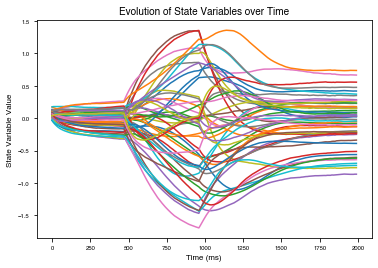

In [8]:
plt.plot(range(0, len(states[0,:,:])*10,10),states[0,:,:])
plt.ylabel("State Variable Value")
plt.xlabel("Time (ms)")
plt.title("Evolution of State Variables over Time")

In [9]:
tf_model.destruct()

## Load from File

Instantiate the simulator from the weights saved to file. Because the model was originally trained as a [Basic](../apidoc/backend.rst#module-psychrnn.backend.models.basic) model, we will use [BasicSimulator](../apidoc/backend.rst#psychrnn.backend.simulation.BasicSimulator) to simulate the model.

In [10]:
simulator = BasicSimulator(weights_path='./weights/saved_weights.npz', params = {'dt': 10, 'tau': 100})

Instantiate task to run the simulator on:

In [11]:
pd = PerceptualDiscrimination(dt = 10, tau = 100, T = 2000, N_batch = 128)

### Simulate Model
Simulate [tf_model.test()](../apidoc/backend.rst#psychrnn.backend.rnn.RNN.test) using the simulator's NumPy impelmentation, [simulator.run_trials(x)](../apidoc/backend.rst#psychrnn.backend.simulation.BasicSimulator.run_trials).

In [12]:
x, y, mask, _ = pd.get_trial_batch()
outputs, states = simulator.run_trials(x)

We can plot the results form the simulated model much as we could plot the results from the model in [Simple Example](PerceptualDiscrimination.ipynb#Test-Model). 

Text(0.5, 1.0, 'Output on New Sample')

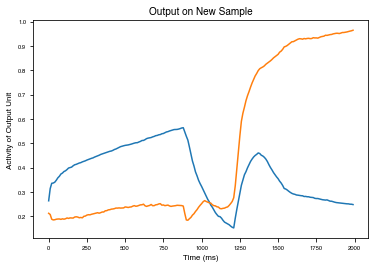

In [13]:
plt.plot(range(0, len(outputs[0,:,:])*10,10),outputs[0,:,:])
plt.ylabel("Activity of Output Unit")
plt.xlabel("Time (ms)")
plt.title("Output on New Sample")

Text(0.5, 1.0, 'Evolution of State Variables over Time')

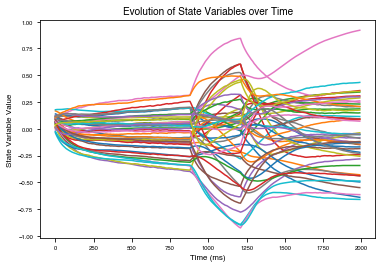

In [14]:
plt.plot(range(0, len(states[0,:,:])*10,10),states[0,:,:])
plt.ylabel("State Variable Value")
plt.xlabel("Time (ms)")
plt.title("Evolution of State Variables over Time")

## Load from Dictionary

Instantiate the simulator from a dictionary of weights. Because the model was originally trained as a [Basic](../apidoc/backend.rst#module-psychrnn.backend.models.basic) model, we will use [BasicSimulator](../apidoc/backend.rst#psychrnn.backend.simulation.BasicSimulator) to simulate the model.

In [15]:
weights = dict(np.load('./weights/saved_weights.npz', allow_pickle = True))
simulator = BasicSimulator(weights = weights , params = {'dt': 10, 'tau': 100})

Instantiate task to run the simulator on:

In [16]:
pd = PerceptualDiscrimination(dt = 10, tau = 100, T = 2000, N_batch = 128)

### Simulate Model
Simulate [tf_model.test()](../apidoc/backend.rst#psychrnn.backend.rnn.RNN.test) using the simulator's NumPy impelmentation, [simulator.run_trials(x)](../apidoc/backend.rst#psychrnn.backend.simulation.BasicSimulator.run_trials).

In [17]:
x, y, mask, _ = pd.get_trial_batch()
outputs, states = simulator.run_trials(x)

We can plot the results form the simulated model much as we could plot the results from the model in [Simple Example](PerceptualDiscrimination.ipynb#Test-Model). 

Text(0.5, 1.0, 'Output on New Sample')

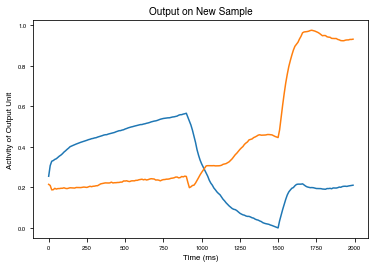

In [18]:
plt.plot(range(0, len(outputs[0,:,:])*10,10),outputs[0,:,:])
plt.ylabel("Activity of Output Unit")
plt.xlabel("Time (ms)")
plt.title("Output on New Sample")

Text(0.5, 1.0, 'Evolution of State Variables over Time')

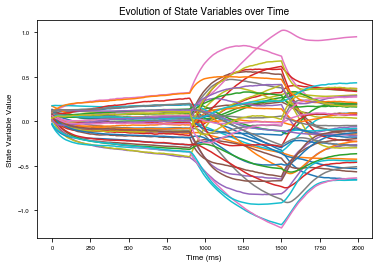

In [19]:
plt.plot(range(0, len(states[0,:,:])*10,10),states[0,:,:])
plt.ylabel("State Variable Value")
plt.xlabel("Time (ms)")
plt.title("Evolution of State Variables over Time")